In [25]:
from pandas_datareader import data
import matplotlib.pyplot as plt,mpld3
import pandas as pd
import datetime
# import plotly.graph_objects as go

<h1 style="color: #5f5fef;"> Getting Data </h1>

#### with ticker

In [27]:
tickers = ['NFLX']
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=(30 * 10))

df = data.DataReader('NFLX', 'yahoo', start_date, end_date)

In [28]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-06-29,447.670013,432.140015,445.230011,447.239990,4844000,447.239990
2020-06-30,457.589996,447.000000,450.019989,455.040009,4198500,455.040009
2020-07-01,488.230011,454.000000,454.000000,485.640015,9705900,485.640015
2020-07-02,492.279999,475.529999,485.640015,476.890015,6351500,476.890015
2020-07-06,499.500000,479.799988,480.769989,493.809998,7839000,493.809998
...,...,...,...,...,...,...
2021-04-16,551.979980,539.510010,550.539978,546.539978,3206000,546.539978
2021-04-19,556.440002,545.530029,546.900024,554.440002,4288700,554.440002
2021-04-20,563.559998,546.299988,554.419983,549.570007,11257600,549.570007


In [29]:
close = df['Close']
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

<h1 style="color: #0f2f1f;">Visualizing</h1>

### adj close with mvg avg

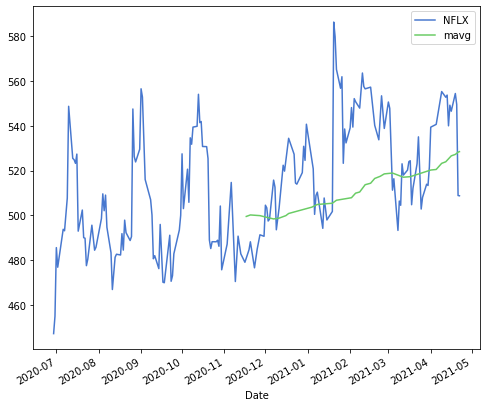

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
# style.use('seaborn-dark')
plt.tight_layout()
plt.style.use(['fast', 'seaborn-muted'])


close_px.plot(label='NFLX')
mavg.plot(label='mavg')
plt.legend()

AttributeError: 'AxesSubplot' object has no attribute 'ticker'

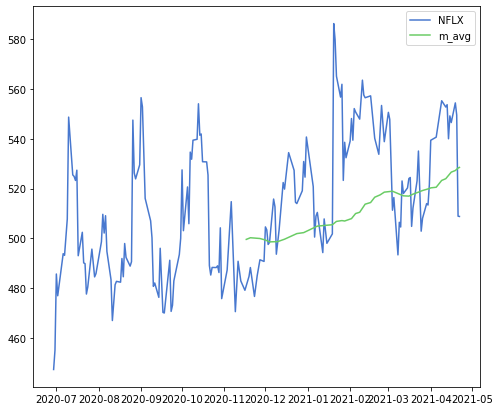

In [32]:
fig, ax = plt.subplots()
ax.plot(close_px.index, close_px, label="NFLX")
ax.plot(mavg.index, mavg, label="m_avg")
ax.legend()
html_text = mpld3.fig_to_html(fig)
ax.tick
mpld3.display()

<h1 style="color: #5f5fef;"> Creating Model </h1>

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

<h3 style="color: #005f0f;"> Feature Engineering </h3>

###### .HL_PCT => High-Low Percentage Change
###### .PCT_change => Pecentage Of Change 

.> High-Low Percent is positive: because there are more new highs than new lows.

.> High-Low Percent is negative (-5.19%) because there are more new lows than new highs.


> (point out at: how PCT_change changes when Adj_Close changes)

In [35]:
dfreg = df.loc[:,['Adj Close','Volume']]

# dfreg['HL_PCT'] = (df['High'] - df['Low']) * 100.0
# dfreg['PCT_change'] = (df['Close'] - df['Open']) * 100.0

dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) /  df['Open'] * 100.0

dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2020-06-29,447.239990,4844000,3.472408,0.451447
2020-06-30,455.040009,4198500,2.327267,1.115510
2020-07-01,485.640015,9705900,7.048433,6.969166
2020-07-02,476.890015,6351500,3.512340,-1.801746
2020-07-06,493.809998,7839000,3.989391,2.712317


## " Here Is Where You Need To Focus "

here we take the previous _______forcast___out___ days data and shift the _forcast____column_ to that number and assign it to a new column named "forcast_column".

So, Basically the previous 1 percent of the data ( 60 days) will act as a label for prediction of 61 day. and thats what we will train our model on

In [36]:
import math
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split


# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

print(dfreg.shape)
# We want to separate 1 percent of the data to forecast
# forecast_out = int(math.ceil(0.1 * len(dfreg)))
forecast_out =60

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

print('Dimension of X',X.shape)
print('Dimension of y',y.shape)
# dfreg.head(5)
X_lately.shape
# dfreg.head()

(206, 4)
Dimension of X (146, 4)
Dimension of y (146,)


(60, 4)

In [40]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X, y)

LinearRegression(n_jobs=-1)

In [41]:
# Printing the forecast
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan
dfreg.shape
# print(forecast_set, confidencereg, forecast_out)

(206, 6)

In [42]:
# dfreg.iloc[250].name
dfreg.columns
# X_lately.iloc[-1].name

Index(['Adj Close', 'Volume', 'HL_PCT', 'PCT_change', 'label', 'Forecast'], dtype='object')

In [43]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
#     print(next_date)
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
     

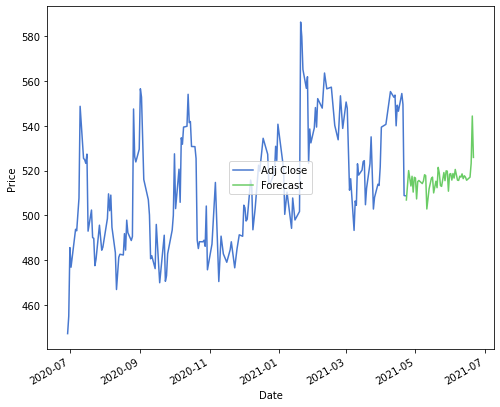

In [44]:
dfreg['Adj Close'].plot()
dfreg['Forecast'].plot()
plt.legend(loc=10)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [45]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(dfreg['Adj Close'].index, dfreg['Adj Close'], label="Adj Close")
ax.plot(dfreg['Forecast'].index, dfreg['Forecast'], label="Forecast")
ax.legend()
html_text = mpld3.fig_to_html(fig)
mpld3.display()

In [46]:
html_text

'\n\n<style>\n\n</style>\n\n<div id="fig_el6651047866347042018200938"></div>\n<script>\nfunction mpld3_load_lib(url, callback){\n  var s = document.createElement(\'script\');\n  s.src = url;\n  s.async = true;\n  s.onreadystatechange = s.onload = callback;\n  s.onerror = function(){console.warn("failed to load library " + url);};\n  document.getElementsByTagName("head")[0].appendChild(s);\n}\n\nif(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){\n   // already loaded: just create the figure\n   !function(mpld3){\n       \n       mpld3.draw_figure("fig_el6651047866347042018200938", {"width": 360.0, "height": 360.0, "axes": [{"bbox": [0.125, 0.125, 0.775, 0.755], "xlim": [18424.15, 18816.85], "ylim": [440.2849884033203, 593.2950286865234], "xdomain": [[2020, 5, 11, 3, 36, 0, 0.0], [2021, 6, 8, 20, 24, 0, 0.0]], "ydomain": [440.2849884033203, 593.2950286865234], "xscale": "date", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 7, "tickvalues": null, "tickformat_format